In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# TensorFlow / Keras Imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    TimeDistributed,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Reshape,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
df.set_index("ts", inplace=True)  # Set timestamp as index

C:\Windows\Temp\ipykernel_28384\3767406237.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample("M").mean()  # Change "W" to "M" for monthly


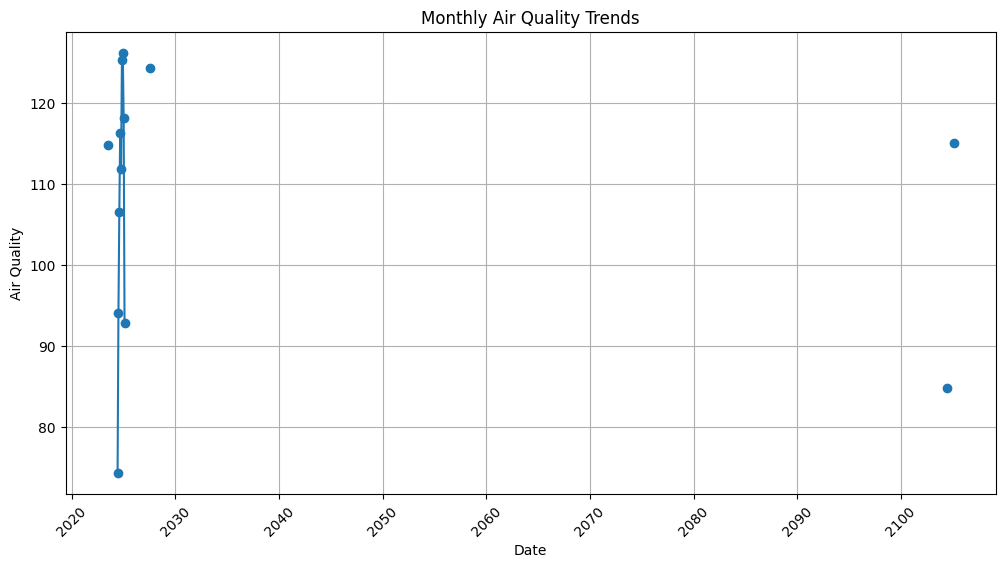

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Resample weekly or monthly (choose based on requirement)
df_resampled = df.resample("M").mean()  # Change "W" to "M" for monthly

plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled["Air Quality"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Air Quality")
plt.title("Monthly Air Quality Trends")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [6]:
df = df[(df.index < "2026-01-01") & (df.index > "2024-01-01")]

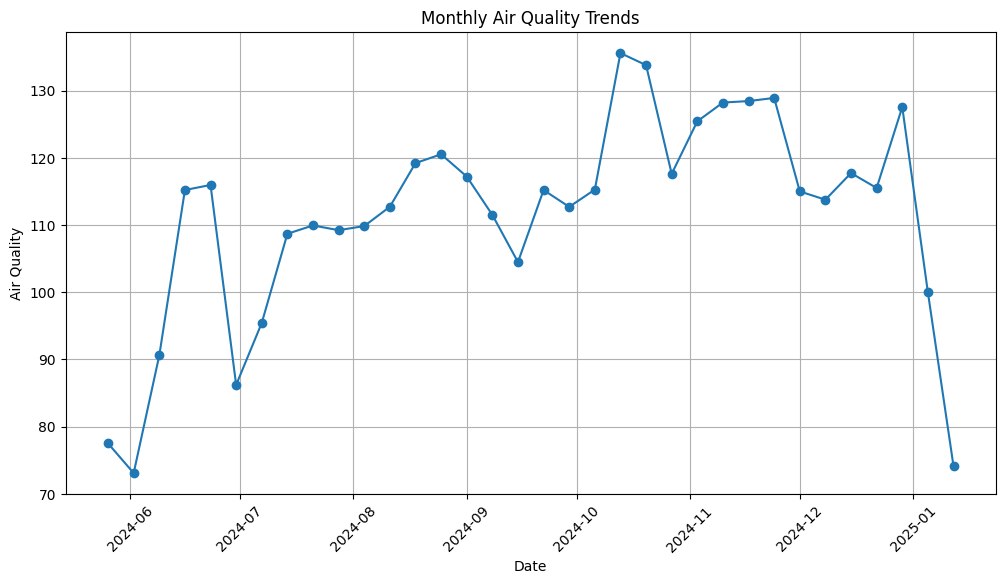

In [7]:
df_resampled = df.resample("W").mean()  # Change "W" to "M" for monthly

plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled["Air Quality"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Air Quality")
plt.title("Monthly Air Quality Trends")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [8]:
# Create a copy of the dataframe
df2 = df.copy()
df2.shape

(589168, 10)

In [9]:
df2["month"] = df2.index.month

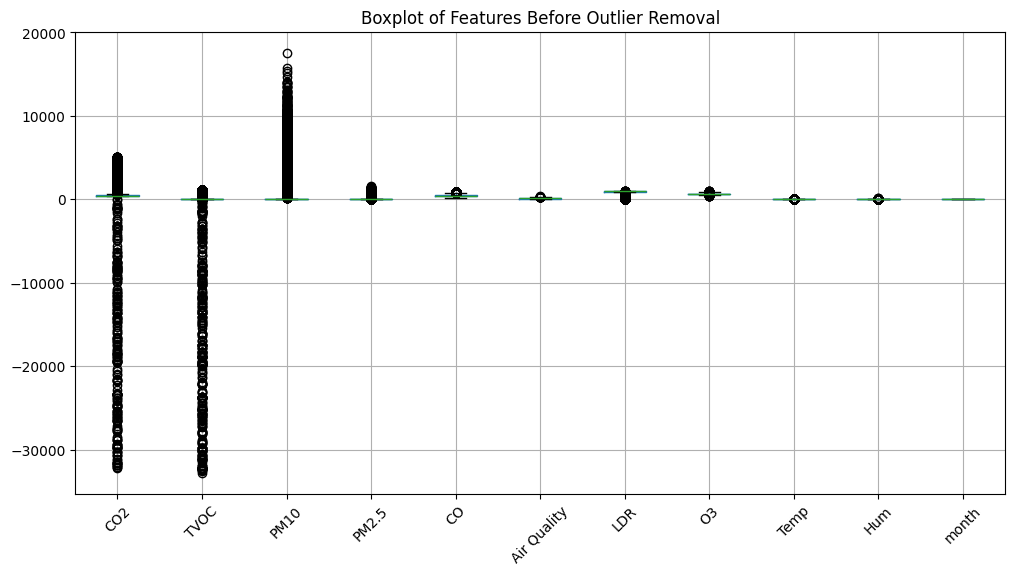

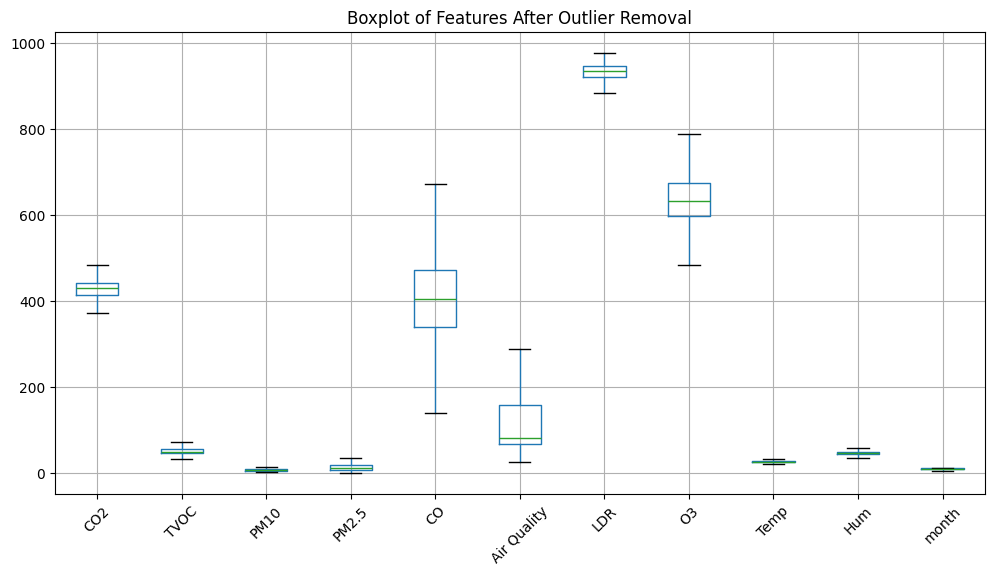

In [10]:
df2_original = df2.copy()

# Get numerical columns list
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()

# Plot the boxplot of the original data (with outliers)
plt.figure(figsize=(12, 6))
df2_original[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features Before Outlier Removal")
plt.show()

# ------------------------------------------------
# Now, remove outliers from df2 and plot again if needed

# Initialize a variable to track the number of rows (for reference)
previous_rows = df2.shape[0]

while True:
    # Calculate Q1, Q3, and IQR for numerical columns
    Q1 = df2[num_cols].quantile(0.25)
    Q3 = df2[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Determine outlier condition for each cell
    outliers = (df2[num_cols] < (Q1 - 1.5 * IQR)) | (df2[num_cols] > (Q3 + 1.5 * IQR))

    # Remove rows with any outliers
    new_df2 = df2[~outliers.any(axis=1)]

    # Check if no rows were removed
    current_rows = new_df2.shape[0]
    if current_rows == previous_rows:
        break  # Stop the loop if no more outliers were removed

    # Update df2 and previous_rows for the next iteration
    df2 = new_df2.copy()
    previous_rows = current_rows

# Optionally, plot the cleaned data boxplot
plt.figure(figsize=(12, 6))
df2[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features After Outlier Removal")
plt.show()

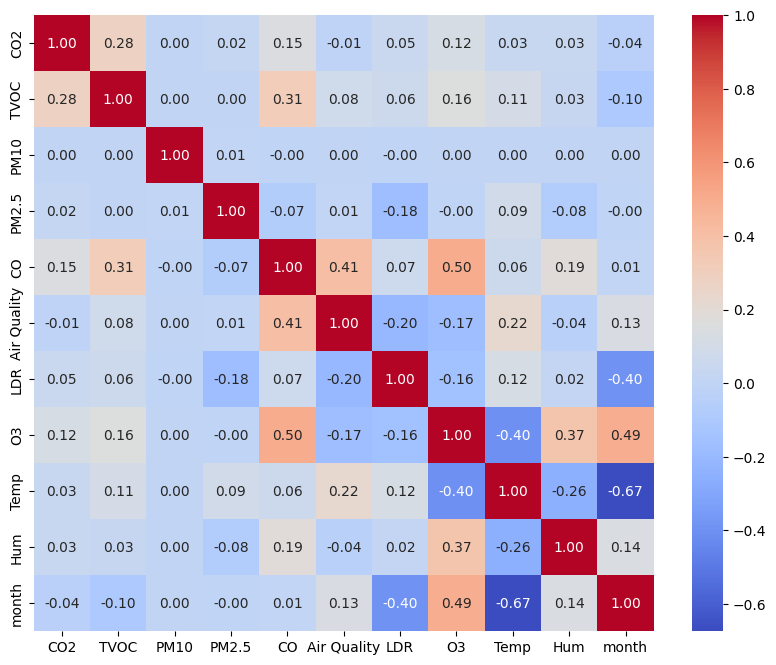

In [11]:
corr_matrix = df2.corr()  # No need to drop anything

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [12]:
def categorize_air_quality(value):
    if value <= 50:
        return "Good"
    elif 51 <= value <= 100:
        return "Moderate"
    elif 101 <= value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif 151 <= value <= 200:
        return "Unhealthy"
    else:
        return "Hazardous"


df2["Air Quality"] = df2["Air Quality"].apply(categorize_air_quality)

In [13]:
def scale_features(data, scaler=None):
    """
    Scales features using StandardScaler. If a scaler is provided, it transforms the data;
    otherwise, it fits and transforms the data using a new StandardScaler instance.

    Parameters:
    X_train (array-like): Feature matrix.
    scaler (StandardScaler, optional): Pre-fitted StandardScaler instance. Defaults to None.

    Returns:
    X_train_scaled (np.array): Scaled feature matrix.
    scaler (StandardScaler): StandardScaler instance used.
    """
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)

    return data_scaled, scaler

In [14]:
def encode_labels(y):
    """
    Encodes categorical labels into integers and ensures a 1D array.

    Parameters:
    y_train (array-like): Original labels.

    Returns:
    y_train_encoded (np.array): Encoded 1D array of labels.
    label_encoder (LabelEncoder): Fitted LabelEncoder instance.
    """
    y = np.ravel(y)  # Ensure 1D
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return y_encoded.squeeze(), le


def generate_sequences(X_train, y_train_encoded, sequence_length=60, target_length=60):
    X_sequences = []
    y_sequences = []

    for i in range(len(X_train) - sequence_length - target_length + 1):
        X_sequences.append(X_train[i : i + sequence_length])
        y_sequences.append(
            y_train_encoded[i + sequence_length : i + sequence_length + target_length]
        )

    return np.array(X_sequences), np.array(y_sequences)

In [15]:
X = df2.drop(axis=1, columns="Air Quality")
y = df2[["Air Quality"]]
y_encoded, le = encode_labels(y)

In [16]:
X.shape, y.shape

((289020, 10), (289020, 1))

In [17]:
X, scaler = scale_features(X)

In [18]:
X.shape

(289020, 10)

In [19]:
y_encoded.shape

(289020,)

In [20]:
X_sequences, y_sequences = generate_sequences(X, y_encoded)
X_sequences.shape, y_sequences.shape

((288901, 60, 10), (288901, 60))

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, shuffle=True
)

In [22]:
X_test.shape

(57781, 60, 10)

In [23]:
X_train.shape, y_train.shape

((231120, 60, 10), (231120, 60))

In [24]:
# y_train = np.ravel(y_train)  # or y_train = y_train.flatten()

# Compute class weights on the encoded labels
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_encoded), y=y_encoded
)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}

print(class_weights)

{0: 4.224203449283835, 1: 7.98618402873722, 2: 0.393918536741606, 3: 0.6771948733569203, 4: 1.6057112697574933}


In [25]:
import tensorflow as tf

# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float16)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int8)

In [26]:
# Create a sample_weight array with the same shape as y_tensor
sample_weight = np.ones_like(y_train_tensor, dtype=np.float32)
# Apply class weights per timestep
for cls, weight in class_weights.items():
    sample_weight[y_train_tensor == cls] = weight

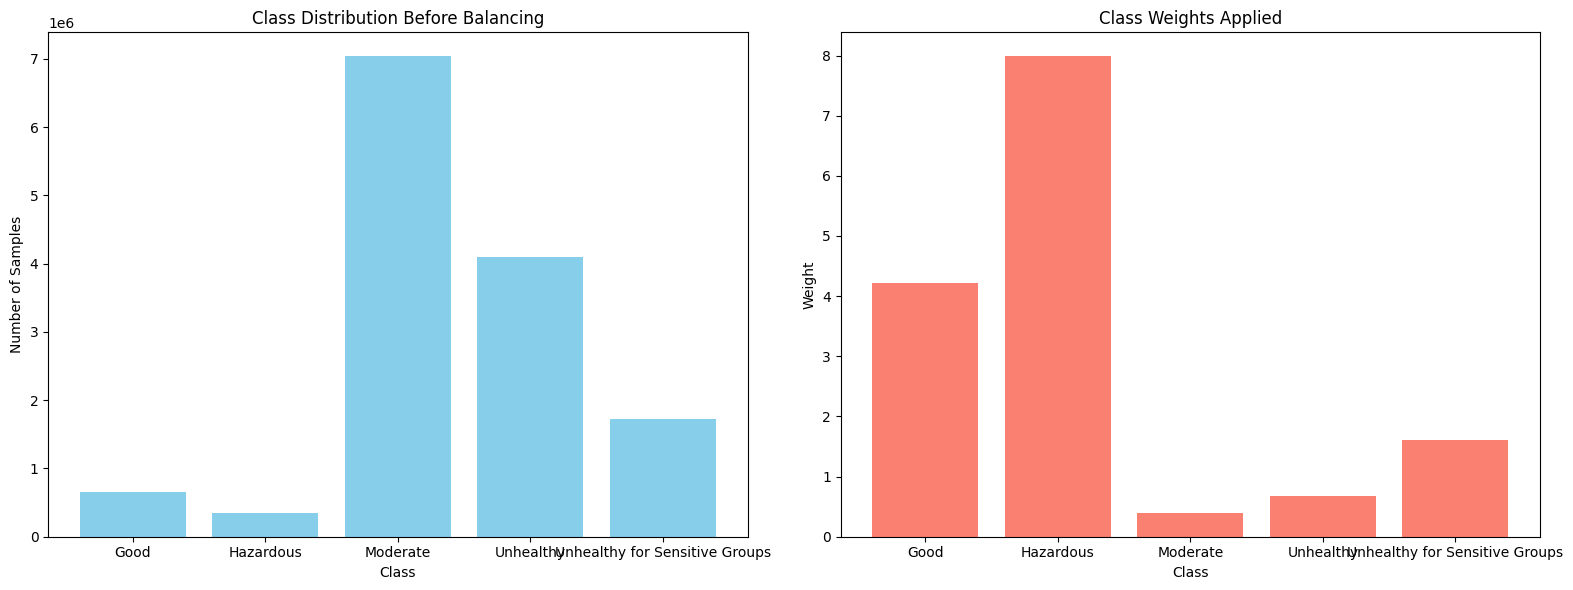

In [27]:
import matplotlib.pyplot as plt
import numpy as np

unique_classes, counts = np.unique(y_train_tensor, return_counts=True)
decoded_classes = le.inverse_transform(unique_classes)

weight_classes = np.array(list(class_weights.keys()))
decoded_weight_classes = le.inverse_transform(weight_classes)
weights = list(class_weights.values())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(decoded_classes, counts, color="skyblue")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Number of Samples")
axs[0].set_title("Class Distribution Before Balancing")

axs[1].bar(decoded_weight_classes, weights, color="salmon")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Weight")
axs[1].set_title("Class Weights Applied")

plt.tight_layout()
plt.show()

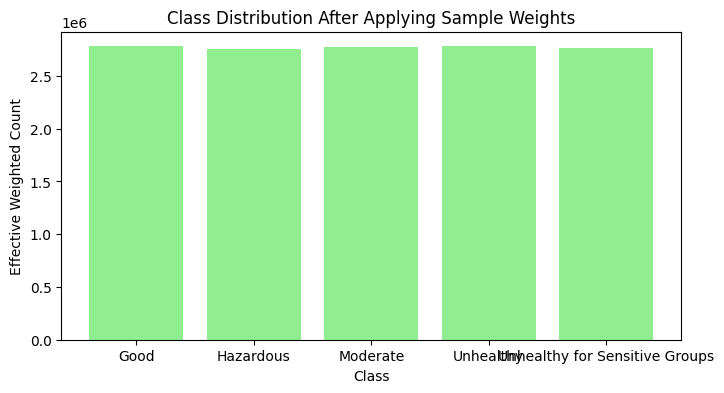

In [28]:
weighted_counts = {
    cls: sample_weight[y_train_tensor == cls].sum() for cls in unique_classes
}

decoded_weighted_classes = le.inverse_transform(list(weighted_counts.keys()))

plt.figure(figsize=(8, 4))
plt.bar(decoded_weighted_classes, list(weighted_counts.values()), color="lightgreen")
plt.xlabel("Class")
plt.ylabel("Effective Weighted Count")
plt.title("Class Distribution After Applying Sample Weights")
plt.show()

# Model building

- using X_train_tensor (298463, 60, 10), y_train_tensor (298463, 60) for modeling 

#### DCNN_model

In [28]:
def build_1DCNN_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Builds and returns a 1D CNN model for air quality classification.
    
    Parameters:
    - sequence_length (int): Number of input timesteps
    - no_features (int): Number of input features
    - num_classes (int): Number of air quality categories
    
    Returns:
    - model (Sequential): Compiled Keras model
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # Stacked 1D convolutional layers for feature extraction
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        
        # Final classification layers
        TimeDistributed(Dense(128, activation='relu')),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

In [29]:
DCNN_model = build_1DCNN_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = DCNN_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

DCNN_model.save("models/DCNN_model.keras")

2025-03-14 07:18:01.159957: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1741929484.248677   12403 service.cc:148] XLA service 0x7eacfc004900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741929484.255181   12403 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-03-14 07:18:04.371675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1741929484.773952   12403 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1741929485.402839   12403 cuda_dnn.cc:529] Loaded cuDNN version 90300


  24/1626 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2515 - loss: 1.4782   

I0000 00:00:1741929494.925981   12403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1624/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6982 - loss: 0.6722

W0000 00:00:1741929501.580375   12404 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6982 - loss: 0.6720

W0000 00:00:1741929509.509182   12404 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1741929512.767539   12402 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.6983 - loss: 0.6720 - val_accuracy: 0.7552 - val_loss: 0.5129
Epoch 2/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7657 - loss: 0.4986 - val_accuracy: 0.7715 - val_loss: 0.4688
Epoch 3/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7865 - loss: 0.4450 - val_accuracy: 0.7856 - val_loss: 0.4260
Epoch 4/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8039 - loss: 0.4011 - val_accuracy: 0.8171 - val_loss: 0.3736
Epoch 5/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8163 - loss: 0.3673 - val_accuracy: 0.8160 - val_loss: 0.3460
Epoch 6/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8296 - loss: 0.3340 - val_accuracy: 0.8278 - val_loss: 0.3291
Epoch 7/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8381 - loss: 0.3131 - val_accuracy: 0.8586 - val_loss: 0.3113
Epoch 8/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8488 - loss: 0.2909 - val_accur

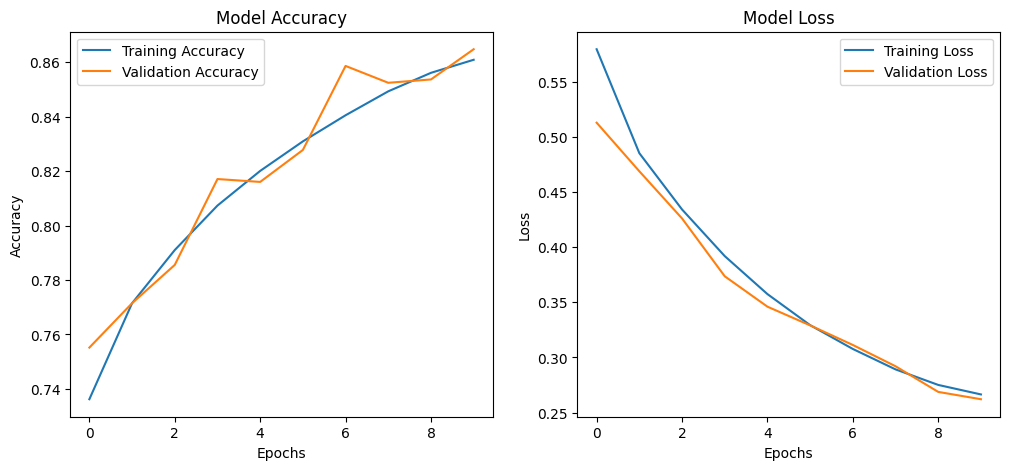

In [30]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### DNN_model

In [31]:
def build_DNN_model(sequence_length=60, no_features=10, num_classes=5):
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(sequence_length * 5),
        Reshape((sequence_length, 5)),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam',metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model

In [32]:
DNN_model = build_DNN_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = DNN_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)
DNN_model.save("models/DNN_model.keras")

2025-03-14 07:19:33.010893: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/10


W0000 00:00:1741929574.876697   12399 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-03-14 07:19:35.935212: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1255', 20 bytes spill stores, 20 bytes spill loads



1614/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7124 - loss: 0.6405

W0000 00:00:1741929580.179791   12400 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7127 - loss: 0.6398

W0000 00:00:1741929582.253163   12400 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1741929582.723754   12402 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7127 - loss: 0.6397 - val_accuracy: 0.7902 - val_loss: 0.4695
Epoch 2/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7744 - loss: 0.4871 - val_accuracy: 0.7630 - val_loss: 0.4543
Epoch 3/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7867 - loss: 0.4599 - val_accuracy: 0.7928 - val_loss: 0.4238
Epoch 4/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7930 - loss: 0.4455 - val_accuracy: 0.7943 - val_loss: 0.4184
Epoch 5/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7958 - loss: 0.4406 - val_accuracy: 0.8232 - val_loss: 0.3961
Epoch 6/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8060 - loss: 0.4200 - val_accuracy: 0.8276 - val_loss: 0.3856
Epoch 7/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8109 - loss: 0.4101 - val_accuracy: 0.8210 - val_loss: 0.3762
Epoch 8/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8147 - loss: 0.4004 - val_accura

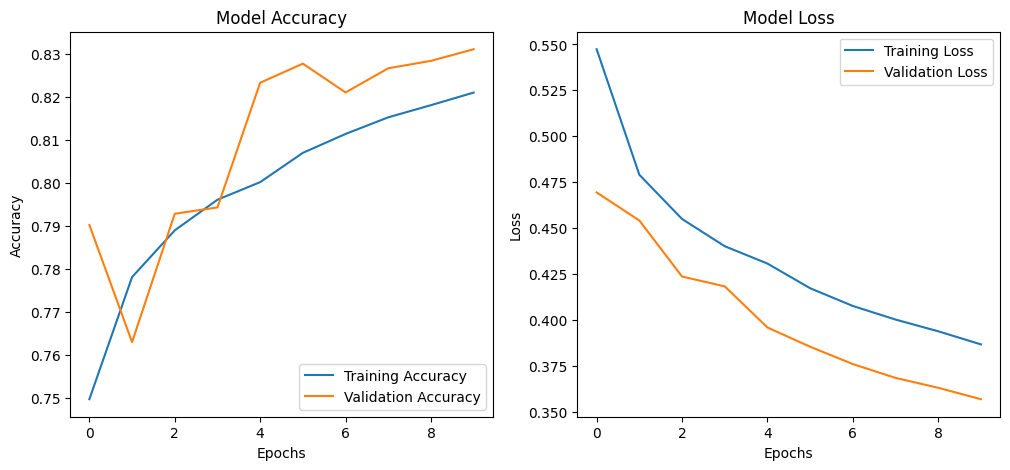

In [33]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

#### RNN_model

In [34]:
def build_RNN_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Builds and returns an RNN model for air quality classification.
    
    Parameters:
    - sequence_length (int): Number of input/output timesteps (60)
    - no_features (int): Number of input features (10)
    - num_classes (int): Number of air quality categories (5)
    
    Returns:
    - model (Sequential): Compiled Keras model
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # Stacked LSTM layers with return_sequences=True
        LSTM(128, return_sequences=True, activation='tanh'),
        LSTM(64, return_sequences=True, activation='tanh'),
        
        # Final classification layers
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [35]:
RNN_model = build_RNN_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = RNN_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)
RNN_model.save("models/RNN_model.keras")

2025-03-14 07:20:09.426241: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.6921 - loss: 0.6919 - val_accuracy: 0.7708 - val_loss: 0.5011
Epoch 2/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7788 - loss: 0.4802 - val_accuracy: 0.8010 - val_loss: 0.4275
Epoch 3/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8177 - loss: 0.3954 - val_accuracy: 0.8448 - val_loss: 0.3545
Epoch 4/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8419 - loss: 0.3430 - val_accuracy: 0.8593 - val_loss: 0.3184
Epoch 5/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8615 - loss: 0.2970 - val_accuracy: 0.8729 - val_loss: 0.2698
Epoch 6/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8726 - loss: 0.2680 - val_accuracy: 0.8839 - val_loss: 0.2502
Epoch 7/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8826 - loss: 0.2396 - val_accuracy: 0.8749 - val_loss: 0.2305
Epoch 8/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8917 -

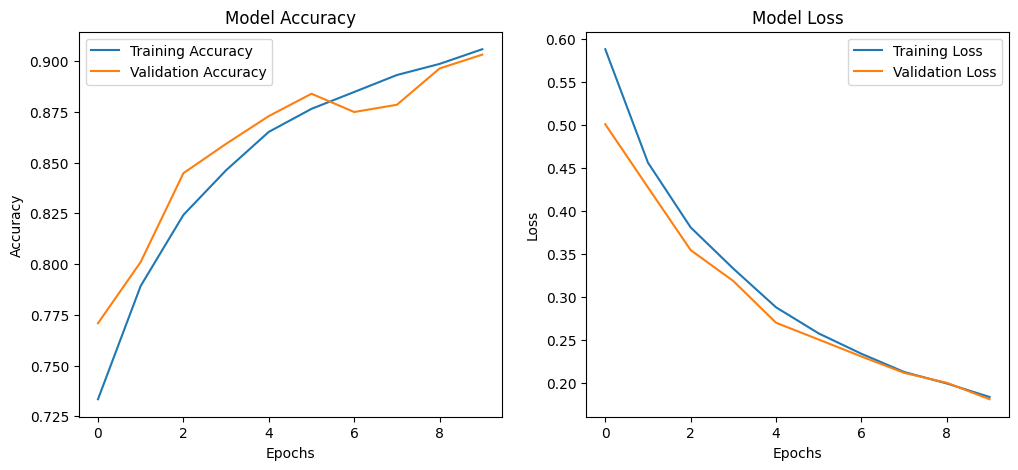

In [36]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

#### lstm_model

In [37]:
def build_lstm_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Standard unidirectional LSTM model for sequence prediction.
    Processes sequences in forward direction only.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # First LSTM layer
        LSTM(128, return_sequences=True, 
            dropout=0.2, recurrent_dropout=0.1),
        
        # Second LSTM layer
        LSTM(64, return_sequences=True),
        
        # Classification head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.2)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [38]:
lstm_model = build_lstm_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = lstm_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

lstm_model.save("models/lstm_model.keras")

2025-03-14 07:24:49.846592: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 137s 79ms/step - accuracy: 0.6358 - loss: 0.8293 - val_accuracy: 0.7389 - val_loss: 0.5735
Epoch 2/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 127s 78ms/step - accuracy: 0.7149 - loss: 0.6166 - val_accuracy: 0.7348 - val_loss: 0.5617
Epoch 3/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 123s 76ms/step - accuracy: 0.7283 - loss: 0.5812 - val_accuracy: 0.7694 - val_loss: 0.5303
Epoch 4/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 122s 75ms/step - accuracy: 0.7381 - loss: 0.5578 - val_accuracy: 0.7823 - val_loss: 0.4973
Epoch 5/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 122s 75ms/step - accuracy: 0.7480 - loss: 0.5343 - val_accuracy: 0.7898 - val_loss: 0.5135
Epoch 6/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 122s 75ms/step - accuracy: 0.7574 - loss: 0.5168 - val_accuracy: 0.7815 - val_loss: 0.4773
Epoch 7/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 122s 75ms/step - accuracy: 0.7600 - loss: 0.5062 - val_accuracy: 0.8045 - val_loss: 0.4561
Epoch 8/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 122s 75ms/step - accuracy: 

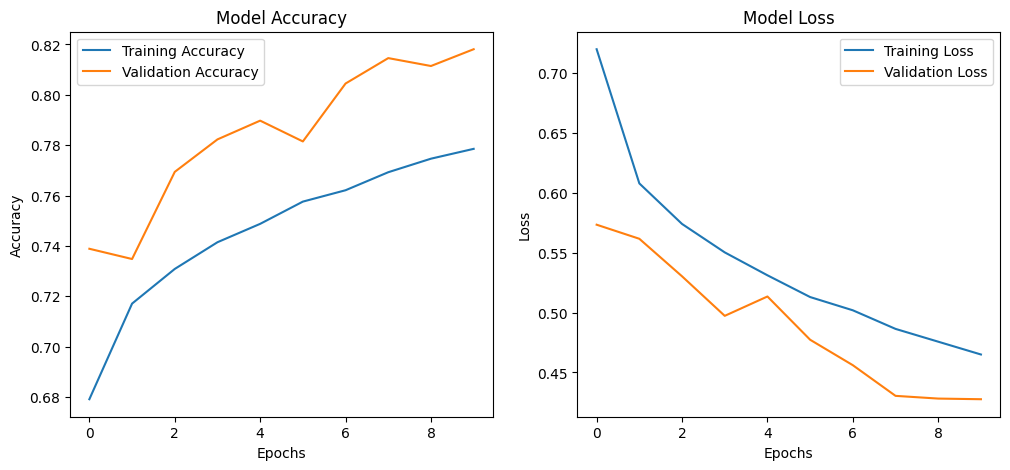

In [39]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### bilstm_model

In [40]:
def build_bilstm_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Bidirectional LSTM model that processes sequences 
    in both forward and backward directions.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # First BiLSTM layer
        Bidirectional(LSTM(64, return_sequences=True,
                          dropout=0.2, recurrent_dropout=0.1)),
        
        # Second BiLSTM layer
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Classification head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.2)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [41]:
bilstm_model = build_bilstm_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = bilstm_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

bilstm_model.save("models/bilstm_model.keras")

2025-03-14 07:45:32.278886: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 191s 112ms/step - accuracy: 0.6636 - loss: 0.7481 - val_accuracy: 0.7484 - val_loss: 0.5409
Epoch 2/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - accuracy: 0.7418 - loss: 0.5570 - val_accuracy: 0.7612 - val_loss: 0.5073
Epoch 3/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - accuracy: 0.7576 - loss: 0.5213 - val_accuracy: 0.7771 - val_loss: 0.4749
Epoch 4/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - accuracy: 0.7681 - loss: 0.4946 - val_accuracy: 0.8026 - val_loss: 0.4649
Epoch 5/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - accuracy: 0.7757 - loss: 0.4803 - val_accuracy: 0.8046 - val_loss: 0.4390
Epoch 6/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - accuracy: 0.7823 - loss: 0.4658 - val_accuracy: 0.8123 - val_loss: 0.4305
Epoch 7/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - accuracy: 0.7868 - loss: 0.4537 - val_accuracy: 0.7972 - val_loss: 0.4420
Epoch 8/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 180s 111ms/step - ac

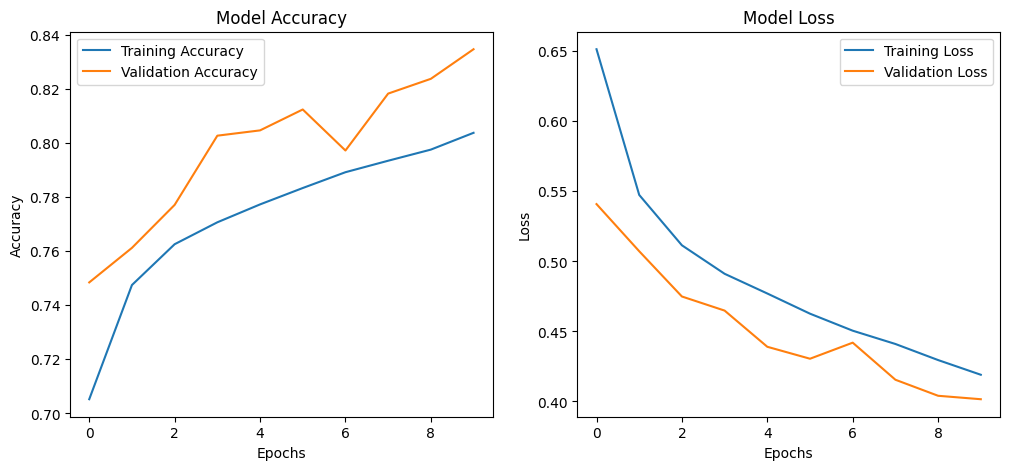

In [42]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### CNN_BILSTM

In [43]:
def build_CNN_BILSTM(sequence_length=60, no_features=10, num_classes=5):
    """
    CNN, BiLSTM
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # CNN Feature Extraction Block
        Conv1D(128, kernel_size=5, activation='relu', padding='causal'),
        BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(64, kernel_size=3, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Bidirectional LSTM Temporal Modeling
        Bidirectional(LSTM(64, return_sequences=True, 
                         dropout=0.2, recurrent_dropout=0.1)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Classification Head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.1)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [44]:
CNN_BILSTM = build_CNN_BILSTM()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = CNN_BILSTM.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

CNN_BILSTM.save("models/CNN_BILSTM.keras")

Epoch 1/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 240s 141ms/step - accuracy: 0.7202 - loss: 0.6194 - val_accuracy: 0.7463 - val_loss: 0.4817
Epoch 2/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - accuracy: 0.7753 - loss: 0.4822 - val_accuracy: 0.7886 - val_loss: 0.4317
Epoch 3/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - accuracy: 0.7900 - loss: 0.4489 - val_accuracy: 0.7968 - val_loss: 0.4101
Epoch 4/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - accuracy: 0.8002 - loss: 0.4285 - val_accuracy: 0.8192 - val_loss: 0.3767
Epoch 5/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - accuracy: 0.8119 - loss: 0.4056 - val_accuracy: 0.8260 - val_loss: 0.3608
Epoch 6/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - accuracy: 0.8174 - loss: 0.3885 - val_accuracy: 0.8381 - val_loss: 0.3400
Epoch 7/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - accuracy: 0.8280 - loss: 0.3667 - val_accuracy: 0.8351 - val_loss: 0.3269
Epoch 8/10
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 228s 140ms/step - ac

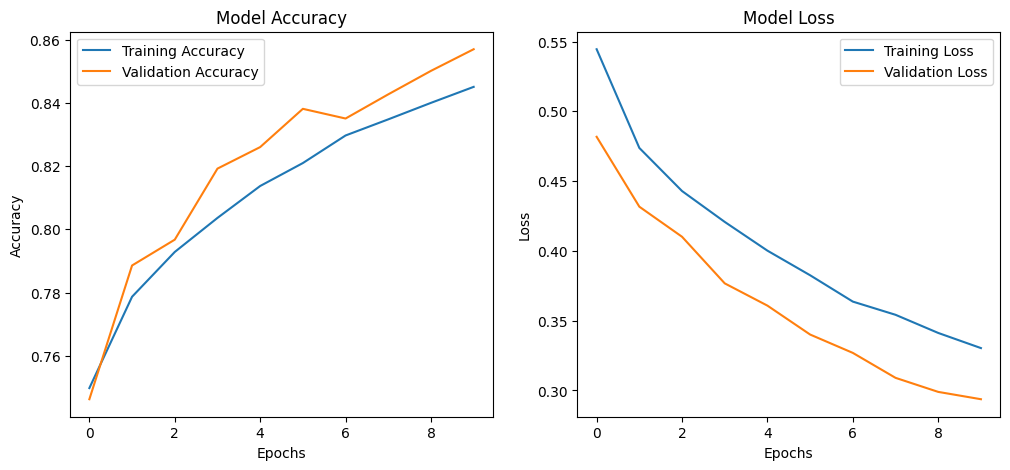

In [45]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### Evaluation

In [ ]:
# X_test, y_test = generate_sequences(X_test, y_test)

In [30]:
def evaluate_model(model, X_test_sequences, y_test_sequences, le):
    """
    Computes accuracy, precision, recall, F1-score, and confusion matrix for the entire test dataset.

    Parameters:
    - model: Trained model.
    - X_test_sequences: Test data sequences.
    - y_test_sequences: True labels.
    - le: Label encoder to transform labels back to original class names.

    Returns:
    - metrics (dict): Dictionary containing accuracy, precision, recall, F1-score, and confusion matrix.
    """
    predictions = model.predict(X_test_sequences)
    int_predictions = np.round(predictions).astype(int)

    # Convert one-hot encoded predictions to class indices
    class_indices = np.argmax(int_predictions, axis=-1).flatten()
    class_predictions = le.inverse_transform(class_indices)

    # Get real class labels
    class_real = le.inverse_transform(y_test_sequences.flatten())

    # Compute metrics
    acc = accuracy_score(class_real, class_predictions)
    prec = precision_score(
        class_real, class_predictions, average="weighted", zero_division=0
    )
    rec = recall_score(
        class_real, class_predictions, average="weighted", zero_division=0
    )
    f1 = f1_score(class_real, class_predictions, average="weighted", zero_division=0)
    conf_matrix = confusion_matrix(class_real, class_predictions)

    metrics = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Confusion Matrix": conf_matrix,
    }

    return metrics

In [29]:
from tensorflow.keras.models import load_model

# Define model paths
model_paths = [
    "models/bilstm_model.keras",
    "models/DCNN_model.keras",
    "models/lstm_model.keras",
    "models/CNN_BILSTM.keras",
    "models/DNN_model.keras",
    "models/RNN_model.keras",
]

# Load models into a dictionary
models = {path.split("/")[-1]: load_model(path) for path in model_paths}

# Access models using their filenames
CNN_BILSTM = models["CNN_BILSTM.keras"]
bilstm_model = models["bilstm_model.keras"]
DCNN_model = models["DCNN_model.keras"]
lstm_model = models["lstm_model.keras"]
DNN_model = models["DNN_model.keras"]
RNN_model = models["RNN_model.keras"]

In [ ]:
# Example: Evaluate each model and store the results in a dictionary
models = {
    'bilstm_model': bilstm_model,
    'DCNN_model': DCNN_model,
    'lstm_model': lstm_model,
    'CNN_BILSTM': CNN_BILSTM,
    'DNN_model': DNN_model,
    'RNN_model': RNN_model
}

results_test = {}
results_train = {}  # if you have train evaluation results as well

for name, model in models.items():
    # Evaluate on test data
    results_test[name] = evaluate_model(model, X_test, y_test, le)
    # Evaluate on train data 
    results_train[name] = evaluate_model(model, X_train, y_train, le)


plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison Across Models')
plt.ylim(0, 1)  # Assuming accuracy is a value between 0 and 1

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.005, f"{yval:.2f}", ha='center', va='bottom')

    
plt.tight_layout()
plt.show()


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 196s 27ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 7s 954us/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 152s 21ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 177s 25ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 6s 786us/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


In [49]:
with open("History/results_test.pkl", "wb") as f:
    pickle.dump(results_test, f)

with open("History/results_train.pkl", "wb") as f:
    pickle.dump(results_train, f)

In [34]:
with open("History/results_test.pkl", "rb") as f:
    results_test = pickle.load(f)

with open("History/results_train.pkl", "rb") as f:
    results_train = pickle.load(f)

In [35]:
# Extract model names and their corresponding test accuracies
model_names = list(results_test.keys())
accuracies = [metrics['Accuracy'] for metrics in [results_test[m] for m in model_names]]


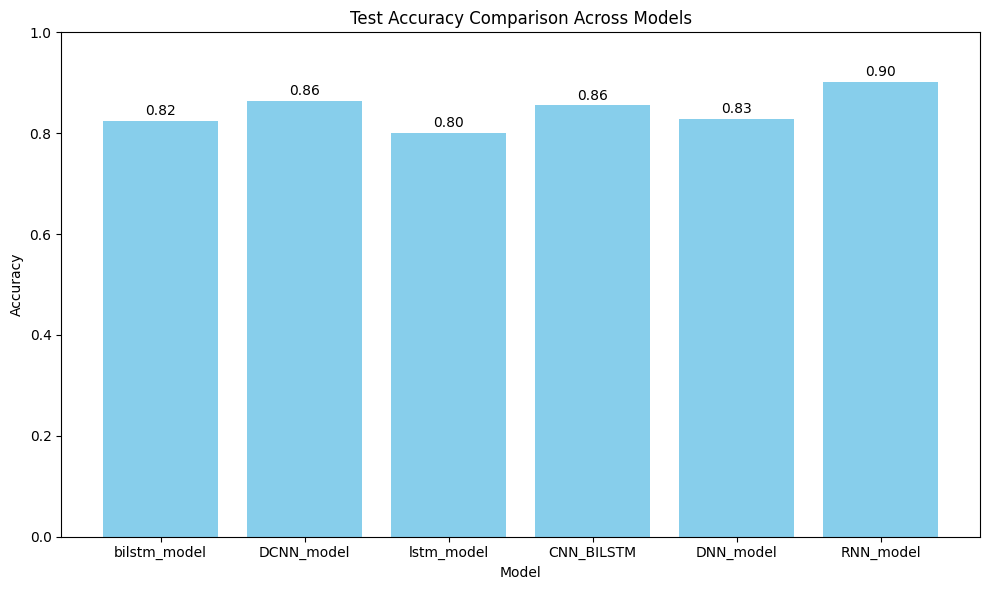

In [36]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison Across Models')
plt.ylim(0, 1)  # Assuming accuracy is a value between 0 and 1

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.005, f"{yval:.2f}", ha='center', va='bottom')

    
plt.tight_layout()
plt.show()


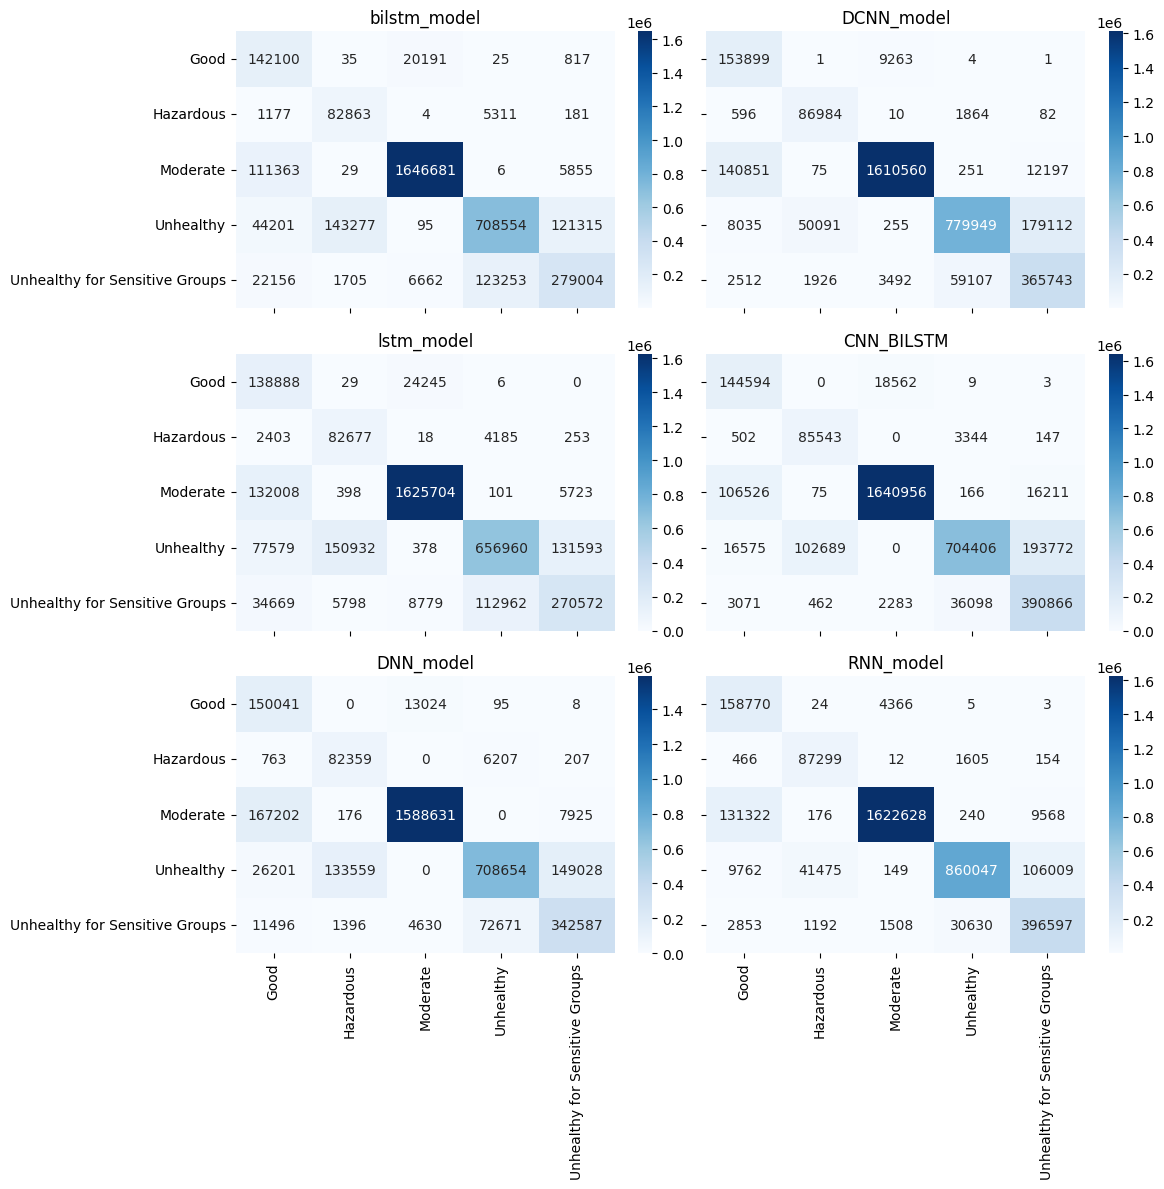

In [37]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_models = len(model_names)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten() 

class_labels = le.inverse_transform(range(len(le.classes_)))

for idx, m in enumerate(model_names):
    ax = axes[idx]
    cm = results_test[m]['Confusion Matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title(m)
    

    if idx < n_models - n_cols:
        ax.set_xticklabels([])
    if idx % n_cols != 0:
        ax.set_yticklabels([])

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [38]:
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']

# For test accuracies (assuming all are present)
test_accuracies = [results_test[model]['Accuracy'] for model in model_names]

# For training accuracies, use .get() to avoid KeyError if a model is missing
train_accuracies = []
for model in model_names:
    model_metrics = results_train.get(model)
    if model_metrics is None:
        print(f"Warning: Training results for '{model}' not found.")
        train_accuracies.append(0)  # or use None, or skip it
    else:
        train_accuracies.append(model_metrics.get('Accuracy', 0))


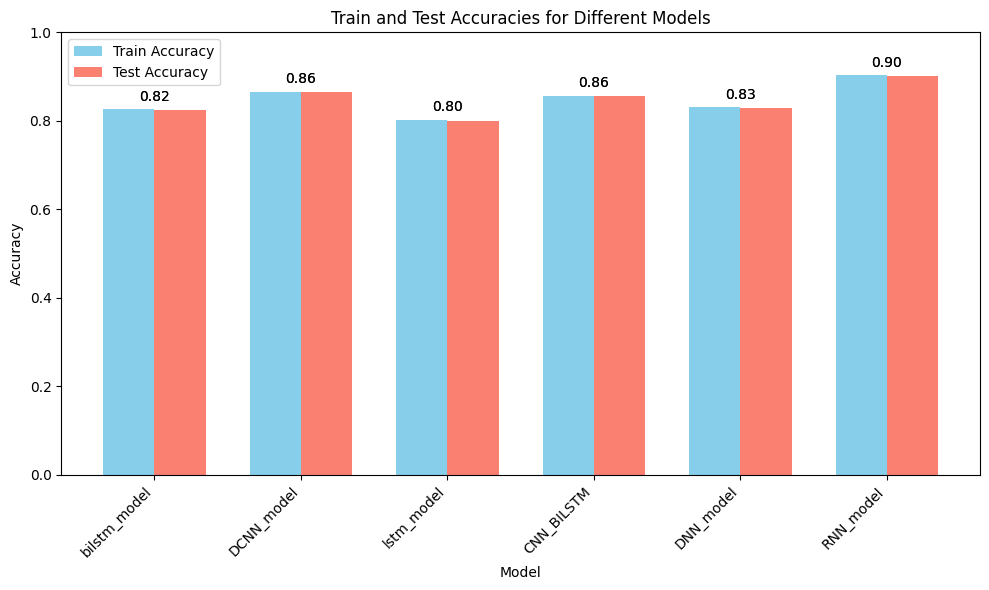

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example model names and corresponding accuracies
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']
test_accuracies = [results_test[model]['Accuracy'] for model in model_names]
train_accuracies = [results_train[model]['Accuracy'] for model in model_names]

# Set positions and width for the bars
x = np.arange(len(model_names))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='skyblue')
bars2 = plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='salmon')

# Adding labels, title, and custom x-axis tick labels
ax = plt.gca()  # get current axes
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()

# Annotate each bar with its accuracy value
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Call the function for both sets of bars
for bars_set in [bars2, bars1]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height + 0.005),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Alternatively, annotate each set separately:
# for bar in bars:
#     height = bar.get_height()
#     ax.annotate(f'{height:.2f}',
#                 xy=(bar.get_x() + bar.get_width() / 2, height),
#                 xytext=(0, 3),
#                 textcoords="offset points",
#                 ha='center', va='bottom')

plt.ylim(0, 1)
plt.title('Train and Test Accuracies for Different Models')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()




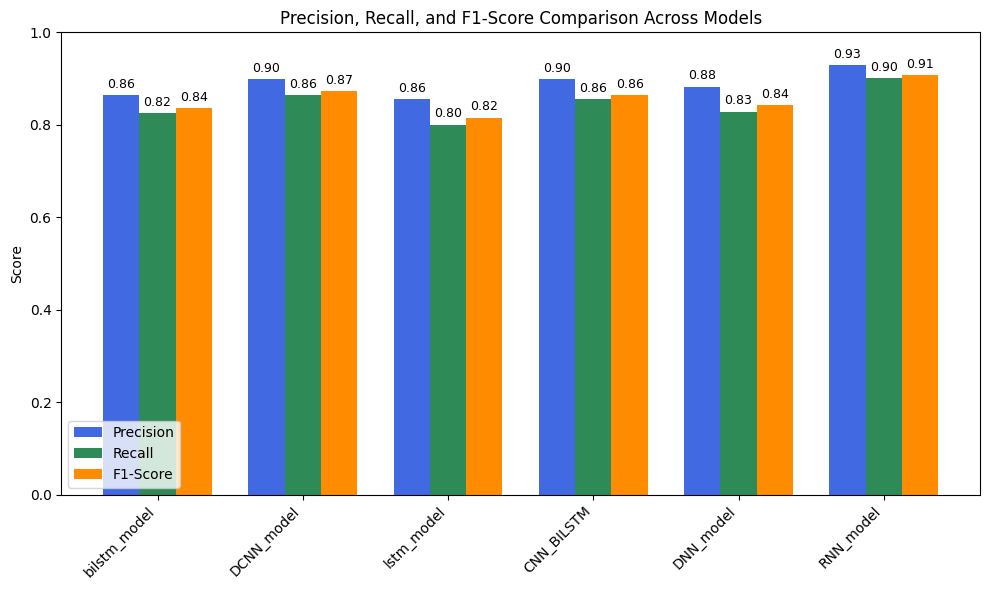

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']

# Extract Precision, Recall, and F1-Score for each model from results_test
precisions = [results_test[model]['Precision'] for model in model_names]
recalls = [results_test[model]['Recall'] for model in model_names]
f1_scores = [results_test[model]['F1-Score'] for model in model_names]

# Define positions and width for the bars
x = np.arange(len(model_names))  # Position of each model
width = 0.25  # Width of each bar

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Precision, Recall, and F1-Score
bars1 = ax.bar(x - width, precisions, width, label='Precision', color='royalblue')
bars2 = ax.bar(x, recalls, width, label='Recall', color='seagreen')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='darkorange')

# Add labels, title, and customize x-axis
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score Comparison Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)  # Since Precision, Recall, and F1-Score are between 0 and 1
ax.legend()

# Function to annotate bars with values
def autolabel(bars):
    """Attach a text label above each bar displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', fontsize=9)

# Apply annotation function to each set of bars
for bars in [bars1, bars2, bars3]:
    autolabel(bars)

# Show plot
plt.tight_layout()
plt.show()


#### Optimization 

- implement Progressive Layer Freezing and Low-Rank Factorization

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_optimized_model(sequence_length=60, no_features=10, num_classes=5):
    """Pure RNN (LSTM) Model with Progressive Freezing support"""
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # First LSTM layer with dropout
        LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
        Dropout(0.2),
        
        # Second LSTM layer
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
        
        # Classification Head with Low-Rank Factorization
        TimeDistributed(Dense(32, use_bias=False)),  # Low-rank layer
        TimeDistributed(Dense(64, activation='relu')),
        Dropout(0.1),
        TimeDistributed(Dense(16, use_bias=False)),  # Low-rank layer
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    return model

# Build and compile the model
optimized_model = build_optimized_model()
optimized_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

class ProgressiveFreezer(tf.keras.callbacks.Callback):
    """Modified Progressive Freezing for RNN architecture"""
    def __init__(self, unfreeze_stages):
        super().__init__()
        self.stages = unfreeze_stages
        self.current_stage = 0
        
    def on_epoch_begin(self, epoch, logs=None):
        if self.current_stage < len(self.stages) and epoch >= self.stages[self.current_stage]:
            print(f"\nUnfreezing stage {self.current_stage+1} layers")
            self._unfreeze_next_stage()
            self.current_stage += 1
            self.model.compile(optimizer=self.model.optimizer,
                             loss=self.model.loss,
                             metrics=self.model.metrics)
            
    def _unfreeze_next_stage(self):
        # Stage 0: Unfreeze second LSTM layer
        # Stage 1: Unfreeze first LSTM layer
        if self.current_stage == 0:
            self.model.layers[2].trainable = True  # Unfreeze second LSTM
        elif self.current_stage == 1:
            self.model.layers[1].trainable = True  # Unfreeze first LSTM

# Initial freezing - freeze all except classification head
for layer in optimized_model.layers[:-4]:
    layer.trainable = False

# Training configuration
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ProgressiveFreezer(unfreeze_stages=[5, 10])  # Unfreeze stages at epochs 5 and 10
]



In [47]:
history = optimized_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=1,  # Increased epochs to accommodate unfreezing stages
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

1626/1626 ━━━━━━━━━━━━━━━━━━━━ 138s 80ms/step - accuracy: 0.4160 - loss: 1.2683 - val_accuracy: 0.6364 - val_loss: 0.8861


In [49]:
optimized_model.save("models/optimized_model.keras")

In [31]:
optimized_model = load_model("models/optimized_model.keras")
models = {"optimized_model": optimized_model, "RNN_model": RNN_model}
results_test = {}
results_train = {}
for name, model in models.items():
    # Evaluate on test data
    results_test[name] = evaluate_model(model, X_test, y_test, le)
    # Evaluate on train data
    results_train[name] = evaluate_model(model, X_train, y_train, le)

# Extract model names and their corresponding test accuracies
model_names = list(results_test.keys())
accuracies = [metrics["Accuracy"] for metrics in [results_test[m] for m in model_names]]

1806/1806 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 148s 21ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 127s 18ms/step


In [33]:
with open("History/results_test_optmized.pkl", "wb") as f:
    pickle.dump(results_test, f)

with open("History/results_train_optmized.pkl", "wb") as f:
    pickle.dump(results_train, f)

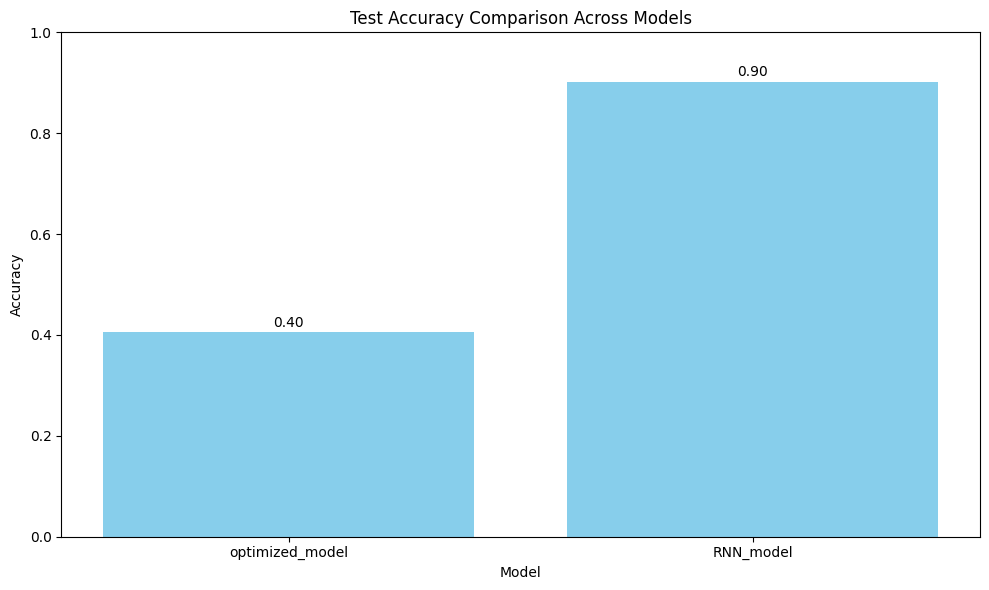

In [32]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison Across Models')
plt.ylim(0, 1)  # Assuming accuracy is a value between 0 and 1

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.005, f"{yval:.2f}", ha='center', va='bottom')

    
plt.tight_layout()
plt.show()
